In [1]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from ml.custom.higgs.analysis.utils import run_chainer

from scipy.stats import norm

In [2]:
class ProbabilityIntegralTransform(BaseEstimator, TransformerMixin):
    """
    Empirical Probability Integral Transform (ECDF) with inverse.
    Transforms each column to Uniform(eps, 1-eps).
    """
    def __init__(self, eps=1e-10):
        self.eps = float(eps)
        self.x_vals_ = None
        self.cdf_vals_ = None
        self.n_samples_ = None
        self.mean_ = None
        self.std_ = None

    def fit(self, X, y=None):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        n, d = X.shape
        self.n_samples_ = n
        self.x_vals_ = []
        self.cdf_vals_ = []
        for j in range(d):
            x = X[:, j]
            sorted_x = np.sort(x)
            uniq, idx_start, counts = np.unique(sorted_x, return_index=True, return_counts=True)
            # average index for duplicates (0-based)
            avg_idx = idx_start + (counts - 1) / 2.0
            # convert to CDF values in (0,1) using (i+0.5)/n rule
            cdf = (avg_idx + 0.5) / n
            cdf = np.clip(cdf, 0.0, 1.0)
            self.x_vals_.append(uniq)
            self.cdf_vals_.append(cdf)
        self.mean_ = 0.0
        self.std_ = 1.0
        return self

    def transform(self, X):
        if self.x_vals_ is None or self.cdf_vals_ is None:
            raise RuntimeError("The transformer has not been fitted yet.")
        X = np.asarray(X)
        single_dim = False
        if X.ndim == 1:
            X = X.reshape(-1, 1)
            single_dim = True
        n, d = X.shape
        if d != len(self.x_vals_):
            raise ValueError("Number of features in X does not match fit data.")
        U = np.empty_like(X, dtype=float)
        for j in range(d):
            U[:, j] = np.interp(
                X[:, j],
                self.x_vals_[j],
                self.cdf_vals_[j],
                left=self.cdf_vals_[j][0],
                right=self.cdf_vals_[j][-1],
            )
        U = (U - 0.5) * np.sqrt(12.0)
        return U.ravel() if single_dim else U

    def inverse_transform(self, U):
        if self.x_vals_ is None or self.cdf_vals_ is None:
            raise RuntimeError("The transformer has not been fitted yet.")
        U = np.asarray(U)
        single_dim = False
        if U.ndim == 1:
            U = U.reshape(-1, 1)
            single_dim = True
        n, d = U.shape
        if d != len(self.x_vals_):
            raise ValueError("Number of features in U does not match fit data.")
        X = np.empty_like(U, dtype=float)
        U = U / np.sqrt(12.0) + 0.5
        for j in range(d):
            X[:, j] = np.interp(
                U[:, j],
                self.cdf_vals_[j],
                self.x_vals_[j],
                left=self.x_vals_[j][0],
                right=self.x_vals_[j][-1],
            )
        return X.ravel() if single_dim else X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

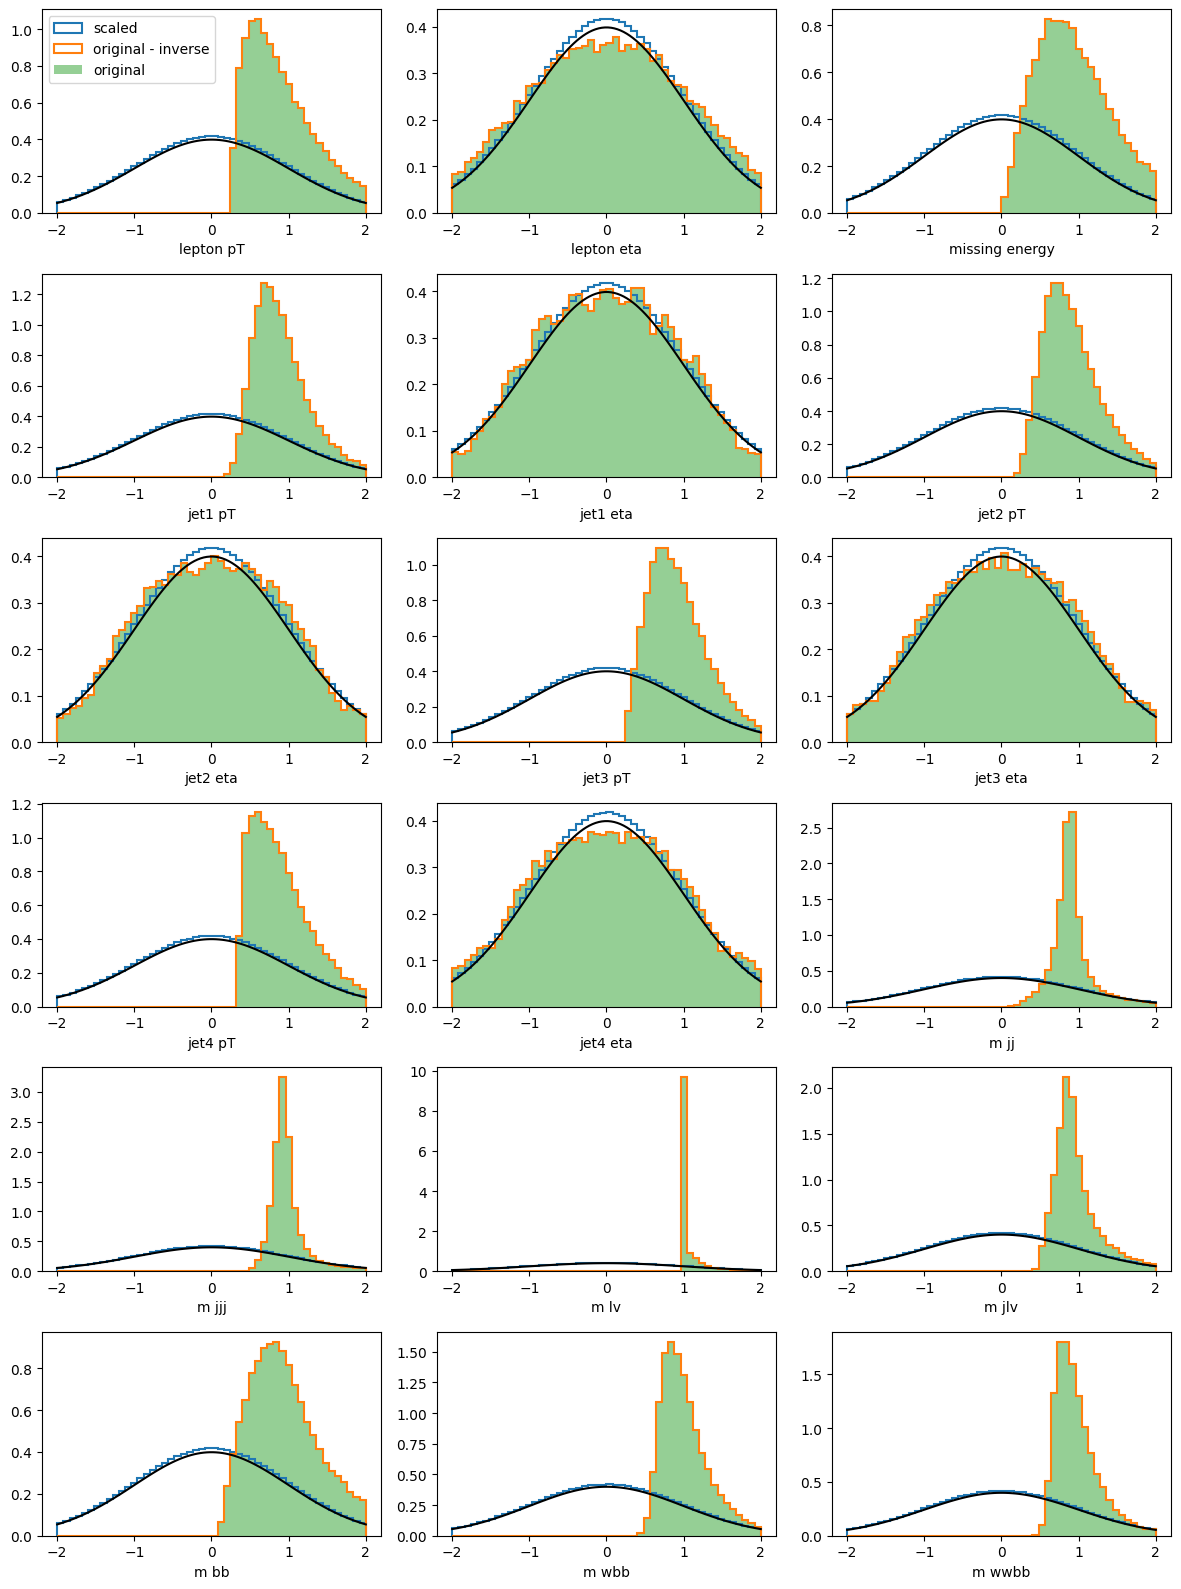

In [3]:
data, selection, scalers = run_chainer(cont_rescale_type="gauss_rank", on_train="bkg", n_data=10**5)

idx = selection[selection["type"] != "label"].index

inv_data = scalers["cont"][0][1].inverse_transform(data[:, idx])
 
fig, axs = plt.subplots(6, 3, figsize=(12, 16))
axs = axs.flatten()

labels = selection[selection["type"] != "label"]["feature"].values

real, selection_r, scalers_r = run_chainer(cont_rescale_type=None, on_train="bkg", n_data=10**5)

x = np.linspace(-2, 2, 100)
s = 1.0

for i, (ax, label) in enumerate(zip(axs, labels)):
    ax.hist(data[:, i], bins=50, histtype="step", lw=1.5, label="scaled", range=(-2, 2), density=True)
    ax.hist(inv_data[:, i], bins=50, histtype="step", lw=1.5, label="original - inverse",  range=(-2, 2), density=True)
    ax.hist(real[:, i], bins=50, lw=1.5, label="original",  range=(-2, 2), density=True, alpha=0.5)
    ax.set_xlabel(label)
    # ax.plot(x, 1/np.sqrt(2*np.pi*s**2) * np.exp(-0.5 * (x/s)**2), '-k', label="norm gauss")
    ax.plot(x, norm.pdf(x,0,1), '-k')


axs[0].legend()

fig.tight_layout()
plt.show()